In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import math
plt.rcdefaults()
%matplotlib inline

In [9]:
def load_df(basePath):
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [ f for f in listdir(basePath) if isfile(join(basePath,f)) ]
    df_list = []
    df = []
    for f in onlyfiles:
        df1 = pd.read_csv(basePath + f, index_col = "loggingTime",parse_dates=True, infer_datetime_format=True)
        if len(df)==0:
            df = df1
        else:
            df = df.append(df1)            
        #df_list.append(df1)
    #df = pd.concat(df_list)
    #a_df = df[["accelerometerAccelerationX","accelerometerAccelerationY","accelerometerAccelerationZ"]]
    #a_df.plot(figsize=(50,10))
    return df

#Features

In [22]:
def get_windows(df):
    gdf = df.groupby(pd.TimeGrouper('1s',closed='left'))
    groups = [group for group in gdf]
    windows = []
    overlap = 3
    for i in range(overlap-1,len(groups)):
        name = groups[i][0]
        windows.append(pd.concat([x[1] for x in groups[i-overlap+1:i+1]]))
    return windows

In [33]:
def extract_features(df_list):
    features_names = ["avg_acc", "max_acc", "min_acc", "avg_gyro", "max_gyro", "min_gyro", "y"]
    f_map = {}
    for fname in features_names:
        f_map[fname] = []
        
    for df in df_list:
        ndf = df[["state"]]
        ndf["acc"] = (df[["accelerometerAccelerationX", "accelerometerAccelerationY", "accelerometerAccelerationZ"]]**2).sum(axis=1)
        ndf["gyro"] = (df[["gyroRotationX", "gyroRotationY", "gyroRotationZ"]]**2).sum(axis=1)    
        agg = ndf.mean()
        if np.isnan(agg["acc"]):
            continue
        f_map["avg_acc"].append(agg["acc"])
        f_map["avg_gyro"].append(agg["gyro"])

        agg = ndf.max()
        f_map["max_acc"].append(agg["acc"])   
        f_map["max_gyro"].append(agg["gyro"])
        f_map["y"].append(agg["state"]+0.1)

        agg = ndf.min()
        f_map["min_acc"].append(agg["acc"])    
        f_map["min_gyro"].append(agg["gyro"])
    return pd.DataFrame(data=f_map)

In [28]:
ndf

NameError: name 'ndf' is not defined

In [5]:
def plot_map(f_map):
    f, ax = plt.subplots(len(f_map), sharex=True,figsize=(10,len(f_map)*3))
    for i,f in enumerate(f_map):
        ax[i].plot(f_map[f])
        ax[i].set_title(f)

## classification

In [19]:
from sklearn import linear_model
from sklearn import preprocessing
import pickle

def predict(df):
    X = df.values
    Y = df["y"].values
    
    scaler = preprocessing.StandardScaler()
    model = linear_model.LogisticRegression(C=1e5)
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, Y)
        pickle.dump(model, open("model.pickle", 'w'))

    pickle.dump(model, open("model.pickle", 'w'))
    return model.predict(X_scaled)

In [137]:
##clustering

In [7]:
def plot_svd(df):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2)
    X_svd = svd.fit_transform(df)
    return X_svd

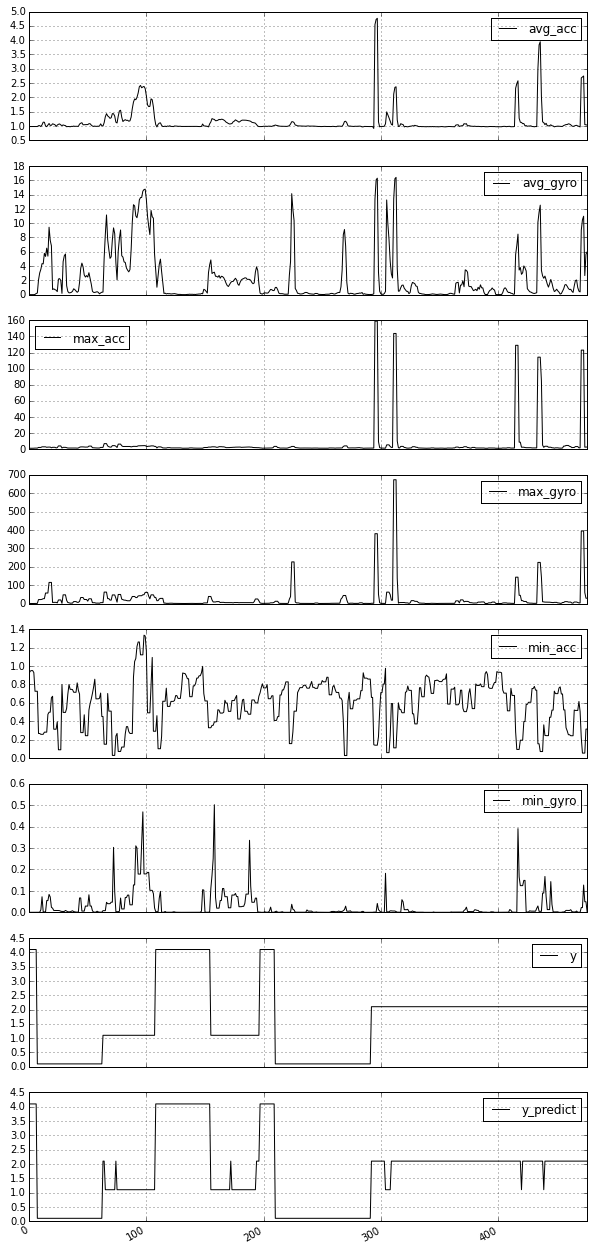

In [35]:
basePath = "/Users/karthik/Documents/workspace/sequoia-ml/data/"
columns = ["accelerometerAccelerationX", "accelerometerAccelerationY", 
           "accelerometerAccelerationZ", "gyroRotationX", "gyroRotationY", "gyroRotationZ",
          "state"]
df = load_df(basePath)
df = df[columns]
df_windowed = get_windows(df)
f_df = extract_features(df_windowed)    
y_predict = predict(f_df)
df_viz = f_df.copy()
df_viz['y_predict'] = pd.Series(data=y_predict, index=f_df.index)
tmp1 = df_viz.plot(subplots=True, figsize=(10,df_viz.columns.size*3))

In [21]:
## scrap

In [ ]:
svd = plot_svd(f_df)
fig = plt.figure(figsize=(20,20))
plt.scatter(svd[:,0],svd[:,1])